In [1]:
#Downloading libraries

%pip install catboost optuna optuna-integration seaborn scikit-learn openpyxl nbformat

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Importing libraries and setting necessery settings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# import all the required models and methods
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
import optuna
from optuna.samplers import TPESampler


%matplotlib inline
plt.style.use("seaborn-v0_8")

c:\Users\Aleks\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **GBM - CatBoost**

In [3]:
# Importing necessary libraries

from catboost import CatBoostRegressor, Pool
from pandas.api.types import is_numeric_dtype
from optuna.integration import CatBoostPruningCallback

In [56]:
cat_data = pd.read_excel("Employee Turnover Analytics Data set.xlsx")

In [57]:
cat_data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [58]:
cat_data.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [59]:
# For further simplicity the target row should be the last

cat_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   sales                  14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [60]:
cat_data.drop(["left", "promotion_last_5years"], axis = 1, inplace = True)

cols = cat_data.columns.tolist()
cols = cols[1:] + cols[:1]
cat_data = cat_data[cols]

In [61]:
# For further simplicity the target row should be the last

cat_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   last_evaluation       14999 non-null  float64
 1   number_project        14999 non-null  int64  
 2   average_montly_hours  14999 non-null  int64  
 3   time_spend_company    14999 non-null  int64  
 4   Work_accident         14999 non-null  int64  
 5   sales                 14999 non-null  object 
 6   salary                14999 non-null  object 
 7   satisfaction_level    14999 non-null  float64
dtypes: float64(2), int64(4), object(2)
memory usage: 937.6+ KB


In [63]:
# Getting categorical feature indecies

def get_categorical_indicies(X):
    cats = []
    for col in X.columns:
        if is_numeric_dtype(X[col]):
            pass
        else:
            cats.append(col)
    cat_indicies = []
    for col in cats:
        cat_indicies.append(X.columns.get_loc(col))
    return cat_indicies


categorical_indicies = get_categorical_indicies(cat_data)

In [64]:
training_set, validation_set = train_test_split(cat_data, test_size=0.1, random_state=777, shuffle=True) 

In [65]:
target = "satisfaction_level"
features = [col for col in cat_data.columns if col != target]

In [73]:
# Find best hyperparameters using Optuna library

def objective(trial, data = training_set[features], target = training_set[target]):

    train_x, test_x, train_y, test_y = train_test_split(data, target,
                                                        test_size=0.25,
                                                        random_state=777)

    param = {
        "n_estimators": trial.suggest_int('n_estimators', 50, 500),
        "learning_rate": trial.suggest_float('learning_rate', 0, 1),
        "depth": trial.suggest_int('depth', 4, 12),
        "l2_leaf_reg": trial.suggest_float('l2_leaf_reg', 0, 10),
        "od_wait": trial.suggest_int("od_wait", 10, 25),
        "border_count": trial.suggest_int('border_count', 100, 500),
        "random_strength": trial.suggest_float('random_strength', 0, 10),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        'grow_policy': trial.suggest_categorical('grow_policy',
            ["Depthwise", "SymmetricTree"])
    }

    if param["bootstrap_type"] == "Bayesian":
      param["bagging_temperature"] = trial.suggest_float(
            "bagging_temperature", 0, 10)

    else:
      param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    if param["grow_policy"] == "Depthwise":
      param["min_data_in_leaf"] = trial.suggest_int('min_data_in_leaf', 1, 500)

    model = CatBoostRegressor(
        loss_function = 'RMSE',
        eval_metric = "RMSE",
        random_state = 777,
        use_best_model = True,
        od_type = "Iter",
        featuresal_indicies,
        per_float_feature_quantization = '0:border_count=1024',
        **param
    )

    model.fit(train_x, train_y, eval_set = [(test_x, test_y)],
              verbose = False)
    preds = model.predict(test_x)
    rmse = root_mean_squared_error(test_y, preds)

    return rmse



sampler = TPESampler(multivariate = True, group = True, seed = 777)
study = optuna.create_study(study_name = "catboost", sampler = sampler)
study.optimize(objective, n_trials = 200)
trial = study.best_trial

print("Number of finished trials: ", len(study.trials))
print("Best trial:", trial.number)
print("  Value: ", trial.value)
print("  Params: ")

for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

c:\Users\Aleks\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\samplers\_tpe\sampler.py:319: ExperimentalWarning:

``multivariate`` option is an experimental feature. The interface can change in the future.

c:\Users\Aleks\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\samplers\_tpe\sampler.py:330: ExperimentalWarning:

``group`` option is an experimental feature. The interface can change in the future.

[I 2024-05-10 21:35:08,549] A new study created in memory with name: catboost
[I 2024-05-10 21:35:11,231] Trial 0 finished with value: 0.18049439671921952 and parameters: {'n_estimators': 118, 'learning_rate': 0.3023566097075212, 'depth': 4, 'l2_leaf_reg': 4.598603416089688, 'od_wait': 23, 'border_count': 471, 'random_strength': 7.269889843190701, 'bootstrap_type': 'Bayesian', 'grow_policy': 'Depthwise', 'bagging_temperature': 5.896137534558643, 'min_data_in_leaf': 172}. Best is trial 0 with value: 0.18049439671921952.
[I 2024-05-10 21:35:13,360] Tria

KeyboardInterrupt: 

In [33]:
# History of optimization

optuna.visualization.plot_optimization_history(study)

In [34]:
# Hyperparameters to score dependency

optuna.visualization.plot_slice(study)

In [35]:
# Hyperparameter importances

optuna.visualization.plot_param_importances(study)

In [38]:
# Creating the model with best hyperparameters

cat_model = CatBoostRegressor(loss_function = 'RMSE',
                        random_state = 777,
                        od_type = "Iter",
                        per_float_feature_quantization = '0:border_count=1024',
                        **study.best_trial.params)

In [74]:
# Creating train Pool

cat_train_data = Pool(
    data = training_set[features],
    label = training_set[target],
    featuresies,
)

cat_model.fit(cat_train_data)

Text(0.5, 1.0, 'Feature Importance')

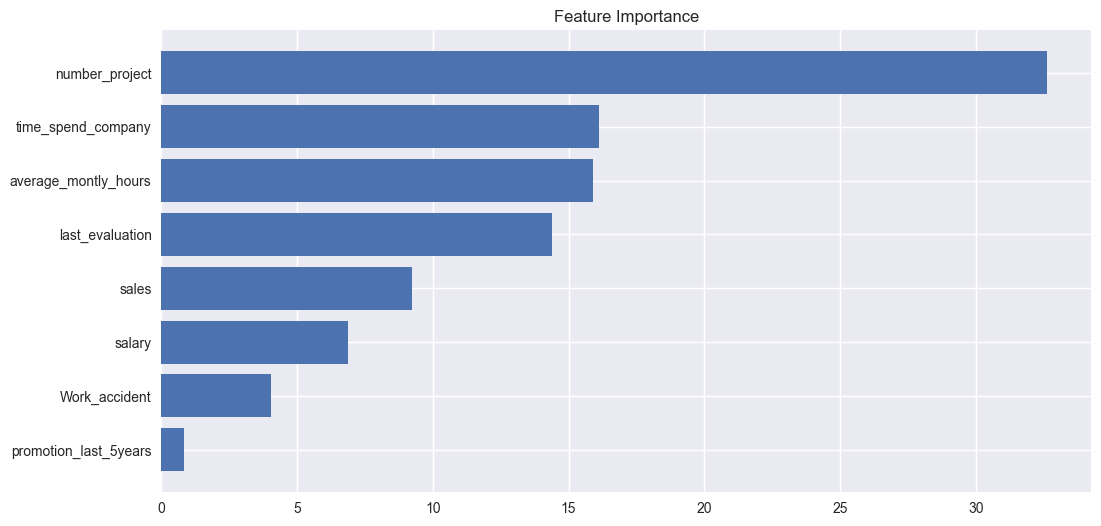

In [41]:
# Plotting feature importance

feature_importance = cat_model.feature_importances_
sorted_idx = np.argsort(feature_importance)

fig = plt.figure(figsize=(12, 6))
plt.barh(np.array(cat_features)[sorted_idx], feature_importance[sorted_idx])
plt.title('Feature Importance')

In [42]:
validation_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1500 entries, 6118 to 9489
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   last_evaluation        1500 non-null   float64
 1   number_project         1500 non-null   int64  
 2   average_montly_hours   1500 non-null   int64  
 3   time_spend_company     1500 non-null   int64  
 4   Work_accident          1500 non-null   int64  
 5   promotion_last_5years  1500 non-null   int64  
 6   sales                  1500 non-null   object 
 7   salary                 1500 non-null   object 
 8   satisfaction_level     1500 non-null   float64
dtypes: float64(2), int64(5), object(2)
memory usage: 117.2+ KB


In [43]:
# Creating Test Pool and predicting

test = Pool(
    data = validation_set[cat_features],
    cat_features = categorical_indicies,
)
y_pred = cat_model.predict(test)

In [44]:
validation_error = root_mean_squared_error(validation_set[target], y_pred)
print("validation:", validation_error, "test:", study.best_trial.value)

validation: 0.18223215475722518 test: 0.1737029593008954
